# 2.8 推論の実施

- 本ファイルでは、学習させたSSDで物体検出を行います。


# 学習目標

1.	SSDの推論を実装できるようになる

# 事前準備

- 学習させた重みパラメータを用意
- フォルダ「utils」のssd_predict_show.pyを使用します

In [1]:
import cv2  # OpenCVライブラリ
import matplotlib.pyplot as plt 
import numpy as np
import torch

%matplotlib inline

# 推論を実行する

In [2]:
from utils.ssd_model import SSD

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

# SSD300の設定
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="inference", cfg=ssd_cfg)

# SSDの学習済みの重みを設定
net_weights = torch.load('./weights/ssd300_50.pth',
                         map_location={'cuda:0': 'cpu'})

# net_weights = torch.load('./weights/ssd300_mAP_77.43_v2.pth',
#                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('ネットワーク設定完了：学習済みの重みをロードしました')


ネットワーク設定完了：学習済みの重みをロードしました


In [3]:
net

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [11]:
import json
from tqdm import tqdm

In [12]:
with open('../../object_detection/data/voc07+12/annotations/instances_val.json') as f:
    image_list = json.load(f)['images']

In [13]:
from utils.ssd_model import DataTransform

ret = []

for d in tqdm(image_list):
    id = d['id']
    file_name = d['file_name']
    # 1. 画像読み込み
    image_file_path = "/home/sato/work/object_detection/data/voc07+12/val/" + file_name
    img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
    height, width, channels = img.shape  # 画像のサイズを取得

#     # 2. 元画像の表示
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.show()

    # 3. 前処理クラスの作成
    color_mean = (104, 117, 123)  # (BGR)の色の平均値
    input_size = 300  # 画像のinputサイズを300×300にする
    transform = DataTransform(input_size, color_mean)

    # 4. 前処理
    phase = "val"
    img_transformed, boxes, labels = transform(
        img, phase, "", "")  # アノテーションはないので、""にする
    img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

    # 5. SSDで予測
    net.eval()  # ネットワークを推論モードへ
    x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 300, 300])
    with torch.no_grad():
        detections = net(x)

    for class_id, row in enumerate(detections.squeeze()):
        for score, xmin, ymin, xmax, ymax in row:
            if score >= 0.01:
                ret.append({
                    'image_id': id,
                    'category_id': class_id,
                    'bbox': [
                        xmin.item() * width,
                        ymin.item() * height,
                        (xmax - xmin).item() * width,
                        (ymax - ymin).item() * height
                    ],
                    'score': score.item()
                })

100%|██████████| 4952/4952 [52:37<00:00,  1.57it/s] 


In [14]:
with open('pred_val_50.json', 'w') as f:
    json.dump(ret, f)

In [25]:
voc_classes[14]

'person'

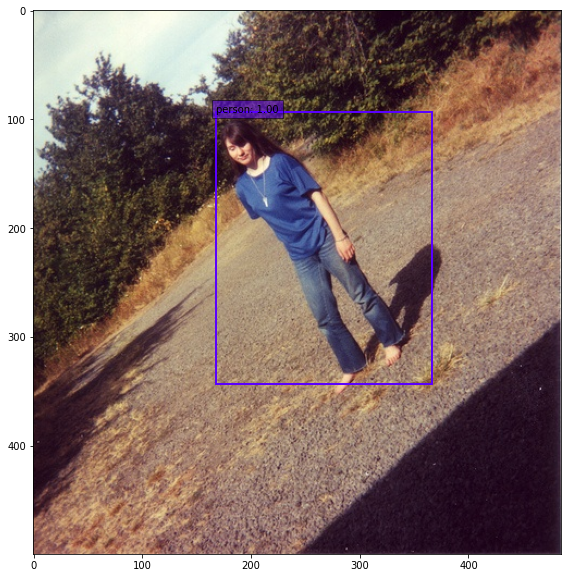

In [8]:
# 画像に対する予測
from utils.ssd_predict_show import SSDPredictShow

# ファイルパス
image_file_path = "./data/VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg"

# 予測と、予測結果を画像で描画する
with torch.no_grad():
    ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
    ssd.show(image_file_path, data_confidence_level=0.6)



以上